<a href="https://colab.research.google.com/github/RuihanWei/COVID-19-Spread-Modelling-Map/blob/master/Jupyter_Scripts/Conv_LSTM_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [145]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [147]:
!pip3 install PyGithub

In [0]:
from github.MainClass import Github
token = "08d6d469a1011245d13062fed5dccd6832206c4f"
g = Github(token)

In [0]:
repo = g.get_repo("CSSEGISandData/COVID-19")
file_list = repo.get_contents("csse_covid_19_data/csse_covid_19_daily_reports")
github_dir_path = 'https://github.com/CSSEGISandData/COVID-19/raw/master/'
csv_list = [path for path in file_list if str(path.path).endswith(".csv")]
paths = [github_dir_path+file_path.path for file_path in csv_list]
canadian_death_list = []

for path in paths:
  df = pd.read_csv(path, error_bad_lines=False)
  if ("Country_Region" not in df.columns):
    df["Country_Region"] = df["Country/Region"]
  if ("Province_State" not in df.columns):
    df["Province_State"] = df["Province/State"]
  # if ("Last_Update" not in df.columns):
  #   df["Last_Update"] = df["Last Update"]
  if ("Deaths" not in df.columns):
    df["Deaths"] = 0
  df = df[df["Country_Region"] == "Canada"]
  canadian_death_list.append(df)

canadian_death_df = pd.concat(canadian_death_list, axis=0, ignore_index=True)

In [150]:
# canadian_death_df = canadian_death_df[canadian_death_df['Last Update'].notnull()]
canadian_death_df = canadian_death_df.dropna(subset=('Last_Update', ))

pd.set_option('display.max_rows', 500)
# ontario_death_df = canadian_death_df[canadian_death_df["Province/State"] == "Ontario"]
# ontario_death_df.plot(x="Last_Update", y="Deaths", style='o')
ontario_death_df = canadian_death_df[canadian_death_df["Province_State"] == "Ontario"]
# ontario_death_df.plot(x="Last_Update", y="Deaths", style='o')
canadian_death_df[(canadian_death_df["Province_State"] == "Ontario")]["Last_Update"]


242           3/22/20 23:48
263     2020-03-23 23:23:10
275     2020-03-24 23:41:36
288     2020-03-25 23:37:36
302     2020-03-26 23:53:11
317     2020-03-27 23:27:32
332           3/28/20 23:10
347           3/29/20 23:13
362           3/30/20 22:58
377     2020-03-31 23:49:13
392     2020-04-01 22:04:44
407            4/2/20 23:31
422     2020-04-03 22:52:30
437            4/4/20 23:40
452     2020-04-05 23:13:28
467            4/6/20 23:28
482     2020-04-07 23:11:15
497     2020-04-08 22:58:44
512     2020-04-09 23:09:01
527     2020-04-10 23:01:26
542     2020-04-11 22:52:28
556     2020-04-12 23:24:00
570     2020-04-13 23:15:25
584     2020-04-14 23:40:54
598     2020-04-15 23:04:09
612     2020-04-16 23:38:03
626     2020-04-17 23:38:31
640     2020-04-18 22:40:03
654     2020-04-19 23:48:49
668     2020-04-20 23:44:34
682     2020-04-21 23:38:53
695     2020-04-22 23:38:42
709     2020-04-24 03:31:19
722     2020-04-25 06:30:55
735     2020-04-26 02:30:54
748     2020-04-27 0

In [0]:
ontario_death_df.reset_index(inplace=True)

In [0]:
time_step = []
deaths = []
for i in range(0, len(ontario_death_df["Deaths"].index)):
  time_step.append(i)
  if (i != 0):
    deaths.append(ontario_death_df["Deaths"].loc[i] - ontario_death_df["Deaths"].loc[i-1])
  else:
    deaths.append(ontario_death_df["Deaths"].loc[i])

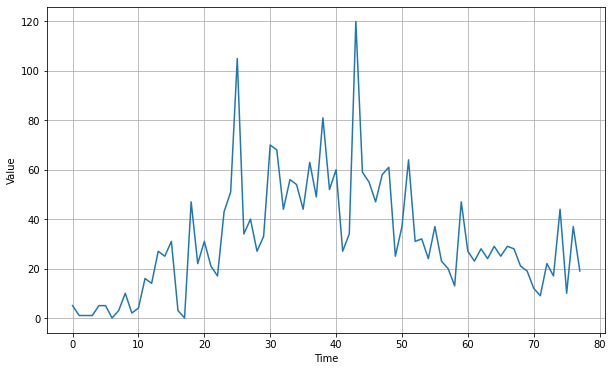

In [153]:
series = np.array(deaths)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 60
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]


In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [157]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 5
batch_size = 20
shuffle_buffer_size = 100
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 45)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=300, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(60,)
Epoch 1/300
3/3 [==============================] - 0s 9ms/step - loss: 35.3526 - mae: 35.8446 - lr: 1.0000e-08
Epoch 2/300
3/3 [==============================] - 0s 5ms/step - loss: 35.3521 - mae: 35.8441 - lr: 1.1220e-08
Epoch 3/300
3/3 [==============================] - 0s 4ms/step - loss: 35.3513 - mae: 35.8433 - lr: 1.2589e-08
Epoch 4/300
3/3 [==============================] - 0s 4ms/step - loss: 35.3501 - mae: 35.8421 - lr: 1.4125e-08
Epoch 5/300
3/3 [==============================] - 0s 4ms/step - loss: 35.3485 - mae: 35.8406 - lr: 1.5849e-08
Epoch 6/300
3/3 [==============================] - 0s 4ms/step - loss: 35.3467 - mae: 35.8387 - lr: 1.7783e-08
Epoch 7/300
3/3 [==============================] - 0s 4ms/step - loss: 35.3445 - mae: 35.8366 - lr: 1.9953e-08
Epoch 8/300
3/3 [==============================] - 0s 5ms/step - loss: 35.3420 - mae: 35.8341 - lr: 2.2387e-08
Epoch 9/300


(1e-08, 0.1, 0.0, 60.0)

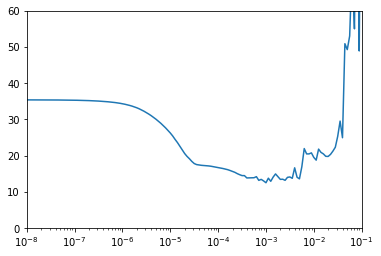

In [158]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-1, 0, 60])

In [171]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 5
batch_size = 20
shuffle_buffer_size = 100
train_set = windowed_dataset(x_train, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 60)
])


# optimizer = tf.keras.optimizers.SGD(lr=1e-5 + 5*1e-5, momentum=0.9)
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
3/3 [==============================] - 0s 6ms/step - loss: 34.9838 - mae: 35.4781
Epoch 2/500
3/3 [==============================] - 0s 5ms/step - loss: 34.1984 - mae: 34.6932
Epoch 3/500
3/3 [==============================] - 0s 4ms/step - loss: 32.8434 - mae: 33.3314
Epoch 4/500
3/3 [==============================] - 0s 4ms/step - loss: 31.1302 - mae: 31.6214
Epoch 5/500
3/3 [==============================] - 0s 4ms/step - loss: 29.2783 - mae: 29.7754
Epoch 6/500
3/3 [==============================] - 0s 4ms/step - loss: 27.5065 - mae: 27.9994
Epoch 7/500
3/3 [==============================] - 0s 4ms/step - loss: 25.7785 - mae: 26.2781
Epoch 8/500
3/3 [==============================] - 0s 4ms/step - loss: 24.1302 - mae: 24.6269
Epoch 9/500
3/3 [==============================] - 0s 6ms/step - loss: 22.5615 - mae: 23.0592
Epoch 10/500
3/3 [==============================] - 0s 4ms/step - loss: 21.3100 - mae: 21.8021
Epoch 11/500
3/3 [==============================] - 0s 4ms/

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

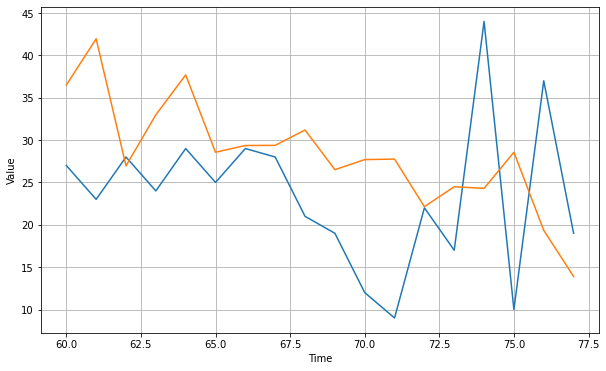

In [173]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [174]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

9.625353

<Figure size 432x288 with 0 Axes>

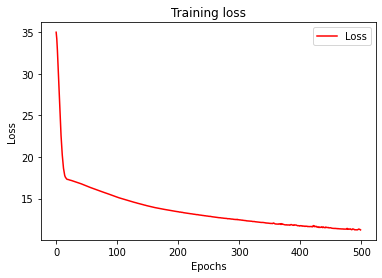

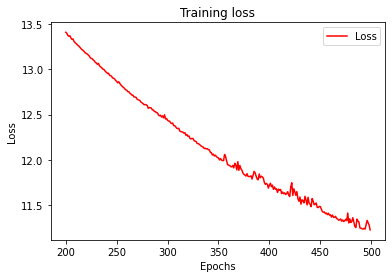

<Figure size 432x288 with 0 Axes>

In [175]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [176]:
print(rnn_forecast)

[36.500046 41.952618 26.956715 32.980206 37.688843 28.56395  29.35938
 29.375225 31.18858  26.504969 27.693897 27.755426 22.14075  24.49013
 24.299583 28.563515 19.343534 13.90137 ]
